In [57]:
import os
import sys
import warnings
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error

sys.path.append(os.path.abspath('.'))
from utils import get_rolling_forecast, forecast_by_last_value, forecast_by_mean

np.random.seed(42)
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# 6. Modeling complex time series

## 6.1 Forecasting bandwidth usage for data centers

## 6.2 Examining the autoregressive moving average process

## 6.3 Identifying a stationary ARMA process

We can simulate an ARMA(1, 1) process:
$$y_t = 0.33y_{t-1} + \epsilon_{t} + 0.9 \epsilon_{t-1} $$
With this simulation, we will see that we cannot use the ACF plot to identify q, nor can we use the PACF plot to identify p of an ARMA(p, q) process. 

In [2]:
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [3]:
ADF_statistic, ADF_p_value, *_ = adfuller(ARMA_1_1)
ADF_statistic, ADF_p_value

(-6.429878682042645, 1.7078466680101036e-08)

The ACF plot shows that the last siginificant coefficient is at lag 2, but we know the simulated data has an MA(1) process. Therefore the ACF plot does not reveal anything about the order q of the ARMA(p=1, q=1) process.

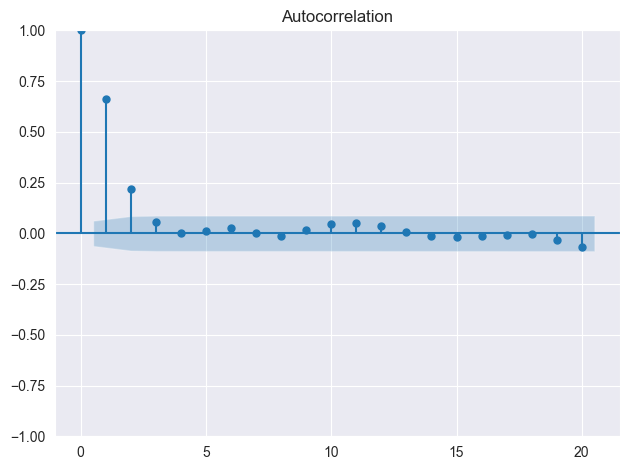

In [4]:
plot_acf(ARMA_1_1, lags=20)
plt.tight_layout()

Similarly, we conclude the PACF plot cannot be used to find the order p of an ARMA(p, q) process. The plot shows that we have significant coefficietns past lag 1, even though the data is generated from an ARMA(1, 1) process.

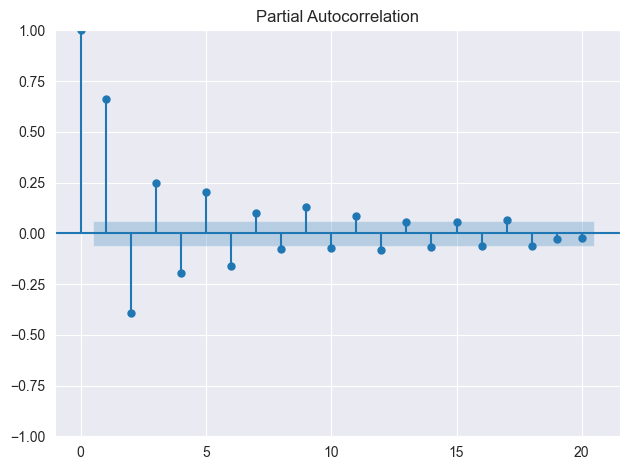

In [5]:
plot_pacf(ARMA_1_1, lags=20)
plt.tight_layout()

## 6.4 Devising a general modeling procedure

### 6.4.1 Understanding the Akaike information criterion (AIC)
AIC quantifies the relative amount of information lost by the model.
$$ AIC = 2k - 2ln(\hat{L})$$
where k is the number of estimated parameters, $\hat{L}$ is the maximum value of likelihood. The less information lost, the lower the AIC value and the better the model.

In the case of an Arma(p, q) model, p + q is the number of estimated parameters, and the likelihood function measures how likely the observed data is coming from this model.
Remember the AIC quantifies the quality of a model in relationship to other models only. 

### 6.4.2 Selecting a model using the AIC
We calculate the AIC for all possible combinations of p and q from a certain range. The results shows that an ARMA(1, 1) model has the lowest AIC value, therefore it's the best model.

In [6]:
def optimize_ARMA(endog, orders) -> list:
    results = []
    for order in orders:
        
        try:
            ar_order, ma_order = order
            model = SARIMAX(
                endog, 
                order=(ar_order, 0, ma_order), 
                simple_differencing=False
            ).fit(disp=False)
        except:
            continue

        results.append((order, model.aic))
    
    # sort by AIC in ascending order
    # lower AIC is better
    return sorted(results, key=lambda x: x[1])

 
ps = range(0, 4, 1)                  
qs = range(0, 4, 1)                  
 
order_list = product(ps, qs)
result = optimize_ARMA(ARMA_1_1, order_list)
pd.DataFrame(result, columns=['(p, q)', 'AIC'])

,"(p, q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2805.930279
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


### 6.4.3 Understanding residual analysis

As opposed to the model's relative quality using AIC, now we consider its absolute quality by performaing residual analysis.
We ask these 2 questions:
1. Does the Q-Q plot show a straight line?
2. Are the residuals uncorrelated (Can we reject the null hypothesis of the, Ljung-Box test, which means the residuals are independently distributed)? 

In [7]:
model = SARIMAX(ARMA_1_1, order=(1, 0, 1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

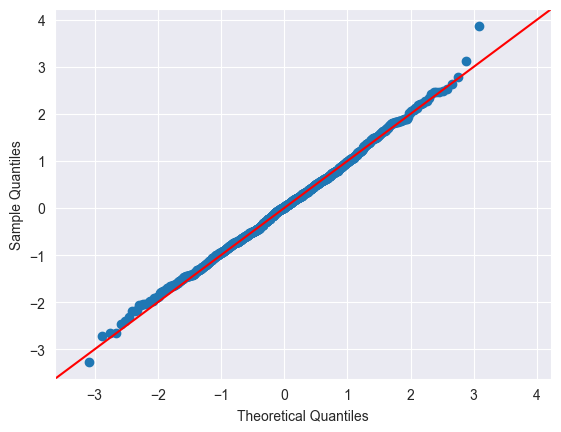

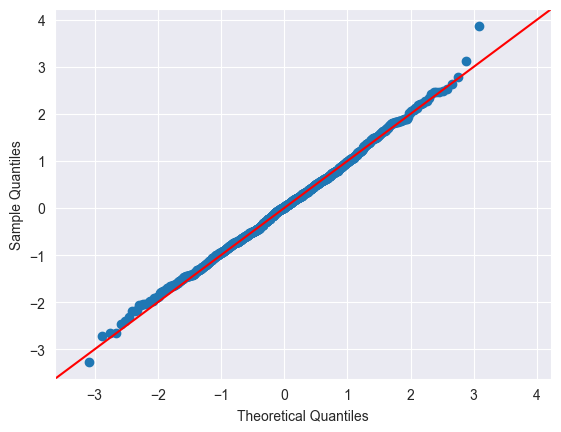

In [13]:
qqplot(residuals, line='45')

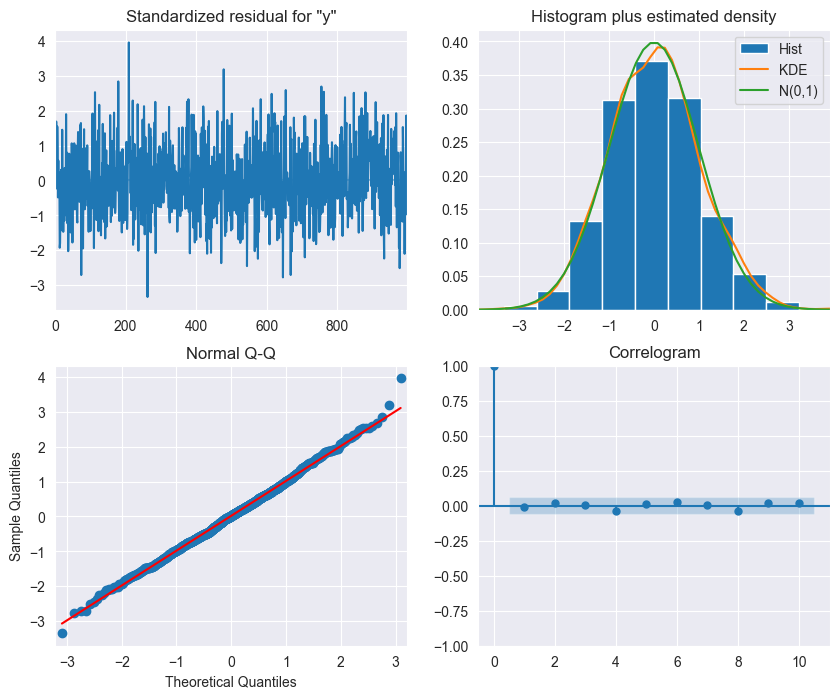

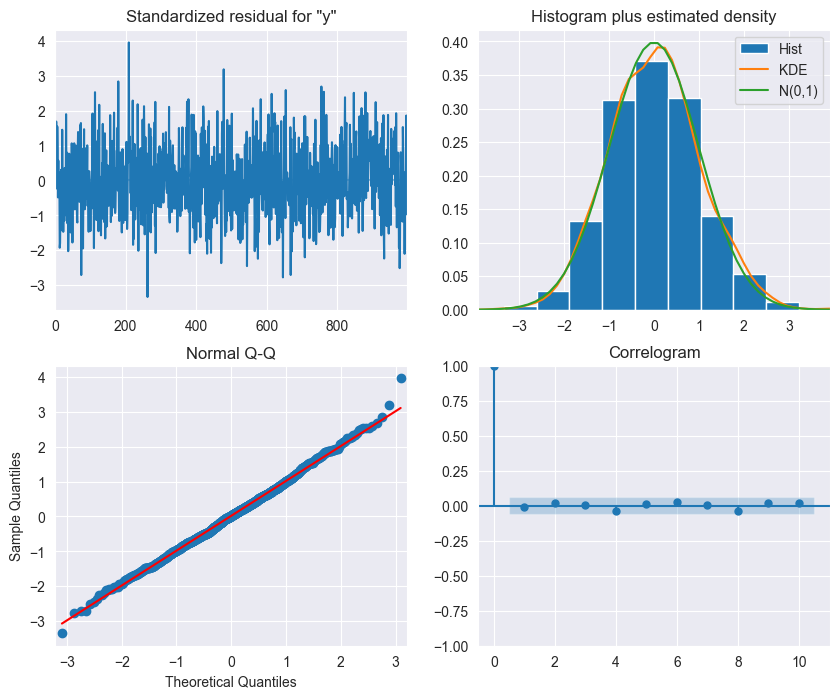

In [14]:
model_fit.plot_diagnostics(figsize=(10, 8))

In [19]:
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.030706,0.860897
2,0.528021,0.767966
3,0.540904,0.909817
4,2.079774,0.721089
5,2.271897,0.810385
6,2.896262,0.821750
7,2.900378,0.894063
8,4.418799,0.817501
9,4.787567,0.852419
10,5.246805,0.874093


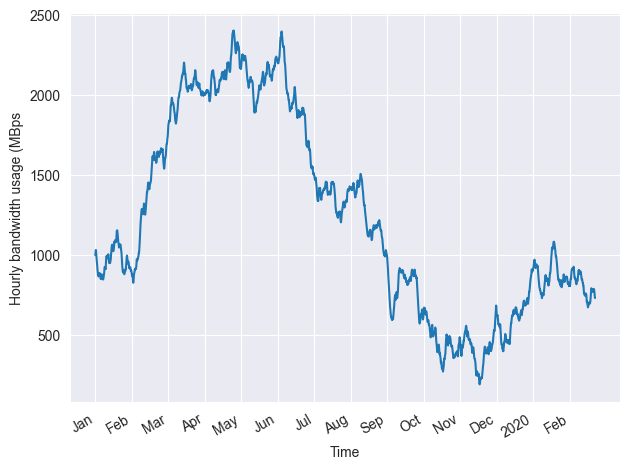

In [22]:
df = pd.read_csv('./data/bandwidth.csv')
fig, ax = plt.subplots()

ax.plot(df.hourly_bandwidth)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth usage (MBps')

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb']
)

fig.autofmt_xdate()
plt.tight_layout()

In [24]:
ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8714653199453133
p-value: 0.7972240255014424


In [26]:
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)

In [27]:
ADF_result = adfuller(bandwidth_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.69485386378899
p-value: 0.0


In [28]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

9831
168


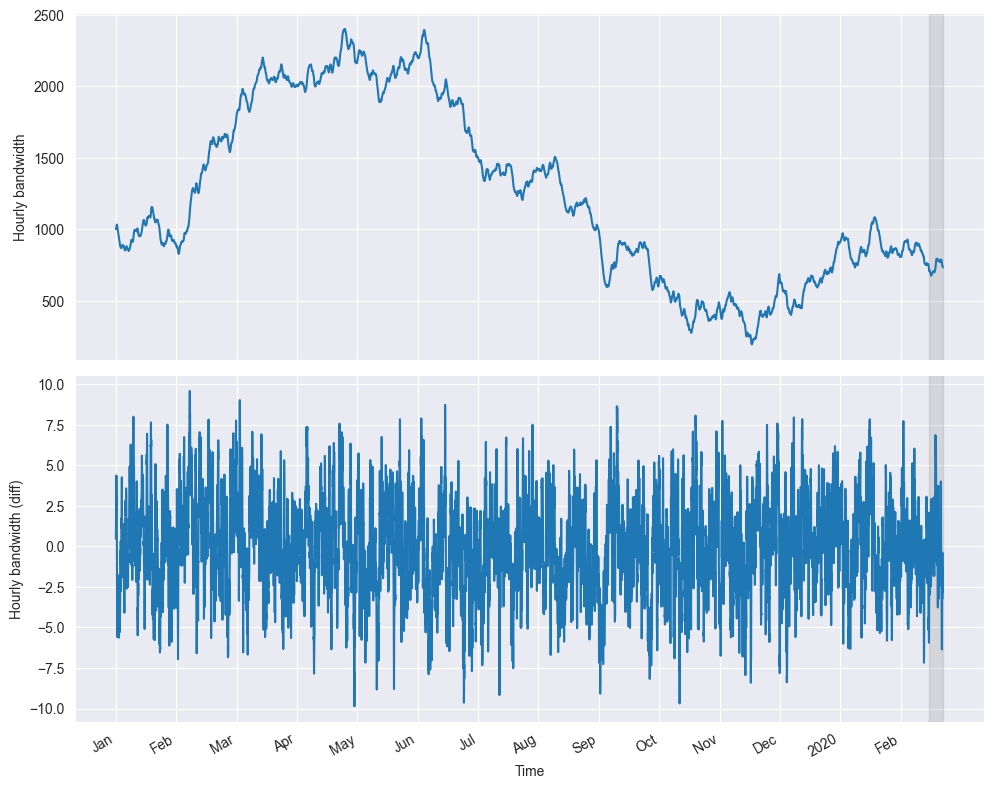

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax2.plot(df_diff.bandwidth_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth (diff)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb']
)

fig.autofmt_xdate()
plt.tight_layout()

In [30]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

orders = list(product(ps, qs))

optimize_ARMA(train['bandwidth_diff'], orders)

[((3, 2), 27991.063878992198),
 ((2, 3), 27991.28750860573),
 ((2, 2), 27991.603597913952),
 ((3, 3), 27993.416924440055),
 ((1, 3), 28003.34954951232),
 ((1, 2), 28051.35140101607),
 ((3, 1), 28071.155497096137),
 ((3, 0), 28095.618185850348),
 ((2, 1), 28097.250766369572),
 ((2, 0), 28098.40766350462),
 ((1, 1), 28172.510044308314),
 ((1, 0), 28941.056983492042),
 ((0, 3), 31355.802140980286),
 ((0, 2), 33531.17928371294),
 ((0, 1), 39402.26952340243),
 ((0, 0), 49035.184224029945)]

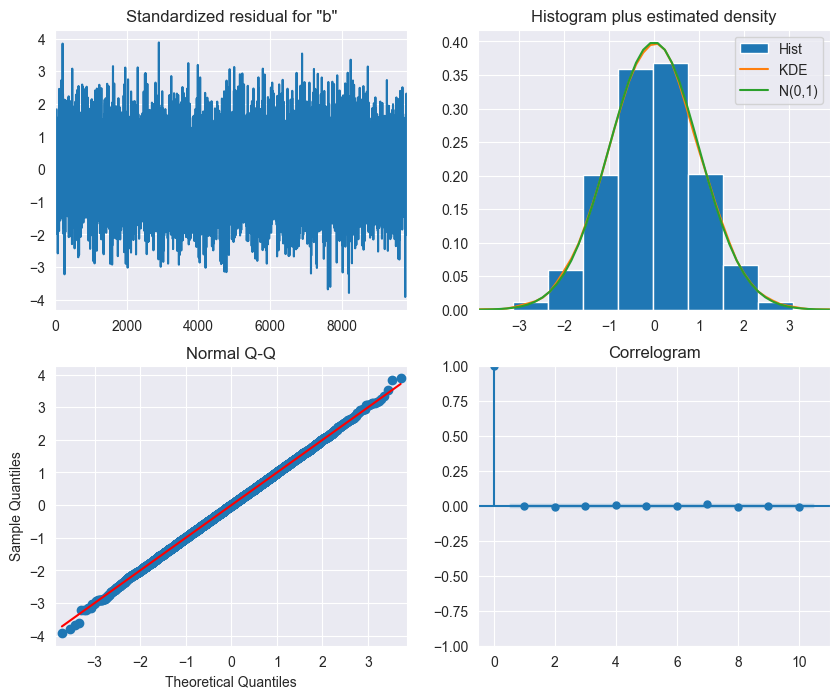

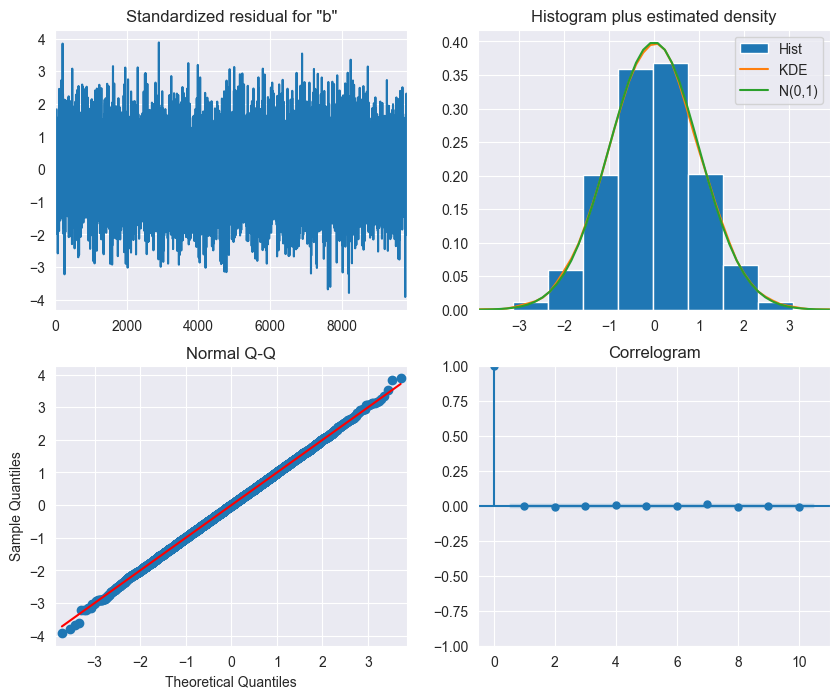

In [31]:
model = SARIMAX(train['bandwidth_diff'], order=(2, 0, 2), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10, 8))

In [32]:
residuals = model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.042190,0.837257
2,0.418364,0.811247
3,0.520271,0.914416
4,0.850555,0.931545
5,0.850841,0.973678
6,1.111754,0.981019
7,2.124864,0.952607
8,3.230558,0.919067
9,3.248662,0.953615
10,3.588289,0.964015


In [51]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

def forecast_by_arma22(data, window):
    model = SARIMAX(data, order=(2, 0, 2))
    res = model.fit(disp=False)
    prediction = res.get_prediction(0, len(data) + window - 1)
    return prediction.predicted_mean[-window:]

diff = df_diff['bandwidth_diff'].tolist()
pred_mean = get_rolling_forecast(forecast_by_mean, diff, TRAIN_LEN, HORIZON, WINDOW)
pred_last_value = get_rolling_forecast(forecast_by_last_value, diff, TRAIN_LEN, HORIZON, WINDOW)
pred_arma = get_rolling_forecast(forecast_by_arma22, diff, TRAIN_LEN, HORIZON, WINDOW)

pred_df = test.copy()
pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_ARMA'] = pred_arma

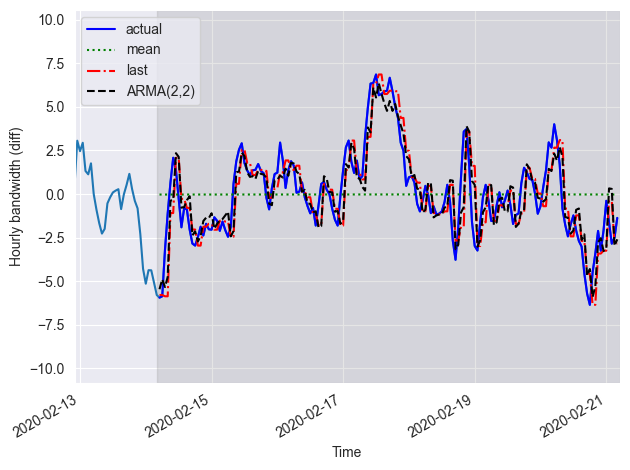

In [52]:
fig, ax = plt.subplots()
ax.plot(df_diff['bandwidth_diff'])
ax.plot(pred_df['bandwidth_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_ARMA'], 'k--', label='ARMA(2,2)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth (diff)')
 
ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)
plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21']\
)

fig.autofmt_xdate()
plt.tight_layout()

In [53]:
mse_mean = mean_squared_error(pred_df['bandwidth_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['bandwidth_diff'], pred_df['pred_last_value'])
mse_ARMA = mean_squared_error(pred_df['bandwidth_diff'], pred_df['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA) 

6.306526957989325 2.2297582947733656 1.7690462113807348


In [54]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + pred_df['pred_ARMA'].cumsum()

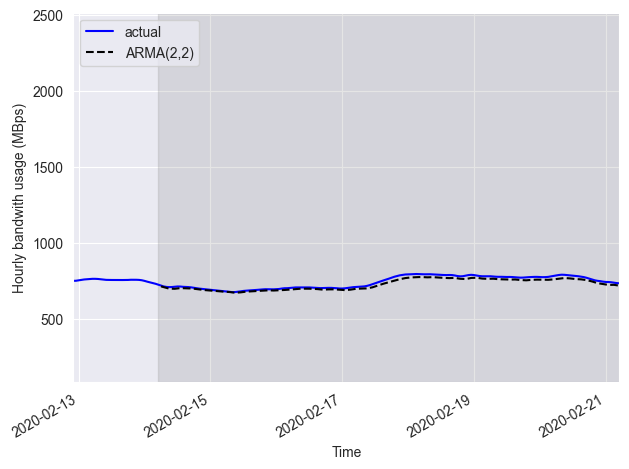

In [56]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')
 
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')
ax.axvspan(9831, 10000, color='#808080', alpha=0.2)
ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21']
)
 
fig.autofmt_xdate()
plt.tight_layout()

In [58]:
mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])

print(mae_ARMA_undiff)

14.000362775548533
